<a href="https://www.kaggle.com/code/ndeekshith/aqi360-air-quality-analysis-ml-forecasting?scriptVersionId=265823280" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/air-quality-data-in-india/stations.csv
/kaggle/input/air-quality-data-in-india/station_hour.csv
/kaggle/input/air-quality-data-in-india/city_day.csv
/kaggle/input/air-quality-data-in-india/city_hour.csv
/kaggle/input/air-quality-data-in-india/station_day.csv


In [2]:
# import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
# Load all datasets
city_day = pd.read_csv('/kaggle/input/air-quality-data-in-india/city_day.csv')
city_hour = pd.read_csv('/kaggle/input/air-quality-data-in-india/city_hour.csv')
station_day = pd.read_csv('/kaggle/input/air-quality-data-in-india/station_day.csv')
station_hour = pd.read_csv('/kaggle/input/air-quality-data-in-india/station_hour.csv')
stations = pd.read_csv('/kaggle/input/air-quality-data-in-india/stations.csv')

print("Data loaded successfully!")
print(f"\nDataset Shapes:")
print(f"city_day: {city_day.shape}")
print(f"city_hour: {city_hour.shape}")
print(f"station_day: {station_day.shape}")
print(f"station_hour: {station_hour.shape}")
print(f"stations: {stations.shape}")

Data loaded successfully!

Dataset Shapes:
city_day: (29531, 16)
city_hour: (707875, 16)
station_day: (108035, 16)
station_hour: (2589083, 16)
stations: (230, 5)


In [4]:
print("=" * 50)
print("CITY_DAY DATASET")
print("=" * 50)
print("\nFirst few rows:")
print(city_day.head())
print("\nData Info:")
print(city_day.info())
print("\nBasic Statistics:")
print(city_day.describe())
print("\nMissing Values:")
print(city_day.isnull().sum())

CITY_DAY DATASET

First few rows:
        City        Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad  2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad  2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad  2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad  2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad  2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  
0  133.36     0.00     0.02    0.00  NaN        NaN  
1   34.06     3.68     5.50    3.77  NaN        NaN  
2   30.70     6.80    16.40    2.25  NaN        NaN  
3   36.08     4.43    10.14    1.00  NaN        NaN  
4   39.31     7.01    18.89    2.78  NaN        NaN  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  D

In [5]:
# Work with city_day dataset (primary focus)
df = city_day.copy()

In [6]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# Check unique values in categorical columns
print("Unique Cities:", df['City'].nunique())
print("Unique AQI Buckets:", df['AQI_Bucket'].unique())

print("\nPreprocessing completed!")
print(f"Dataset shape after feature engineering: {df.shape}")

Unique Cities: 26
Unique AQI Buckets: [nan 'Poor' 'Very Poor' 'Severe' 'Moderate' 'Satisfactory' 'Good']

Preprocessing completed!
Dataset shape after feature engineering: (29531, 21)


In [7]:
# Calculate missing percentage
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_pct.index,
    'Missing_Percentage': missing_pct.values
}).sort_values('Missing_Percentage', ascending=False)

print("Missing Value Analysis:")
print(missing_df[missing_df['Missing_Percentage'] > 0])

Missing Value Analysis:
        Column  Missing_Percentage
13      Xylene           61.322001
3         PM10           37.723071
7          NH3           34.973418
12     Toluene           27.229014
11     Benzene           19.041008
15  AQI_Bucket           15.851139
14         AQI           15.851139
2        PM2.5           15.570079
6          NOx           14.171549
10          O3           13.619586
9          SO2           13.050692
5          NO2           12.139785
4           NO           12.129626
8           CO            6.972334


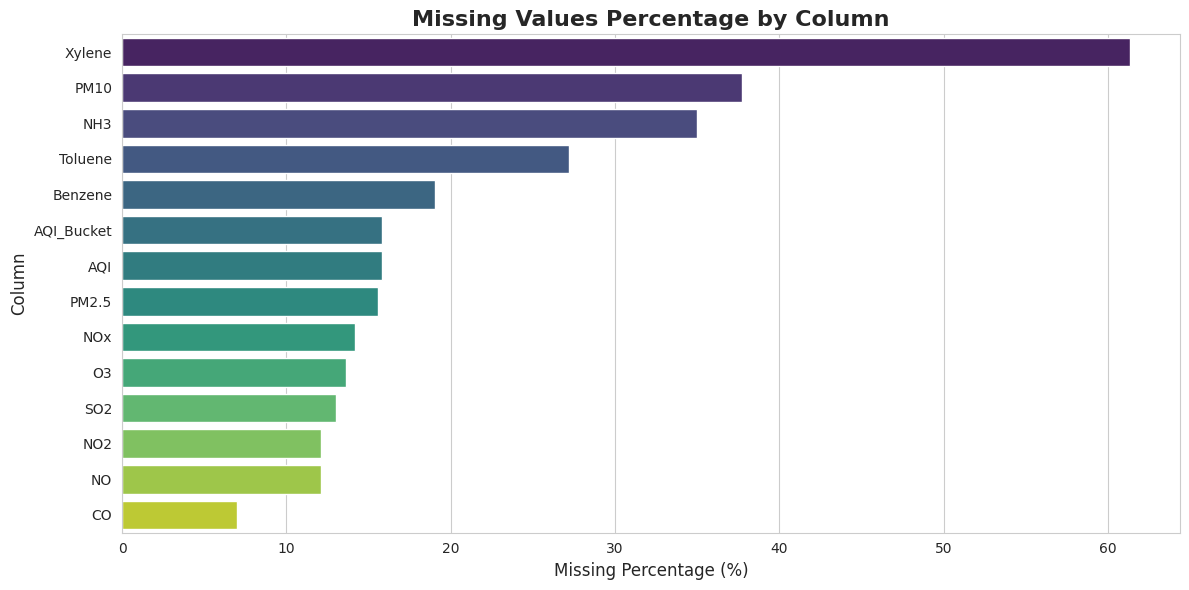

In [8]:
# Visualize missing values
plt.figure(figsize=(12, 6))
missing_df_plot = missing_df[missing_df['Missing_Percentage'] > 0]
sns.barplot(data=missing_df_plot, x='Missing_Percentage', y='Column', palette='viridis')
plt.title('Missing Values Percentage by Column', fontsize=16, fontweight='bold')
plt.xlabel('Missing Percentage (%)', fontsize=12)
plt.ylabel('Column', fontsize=12)
plt.tight_layout()
plt.show()

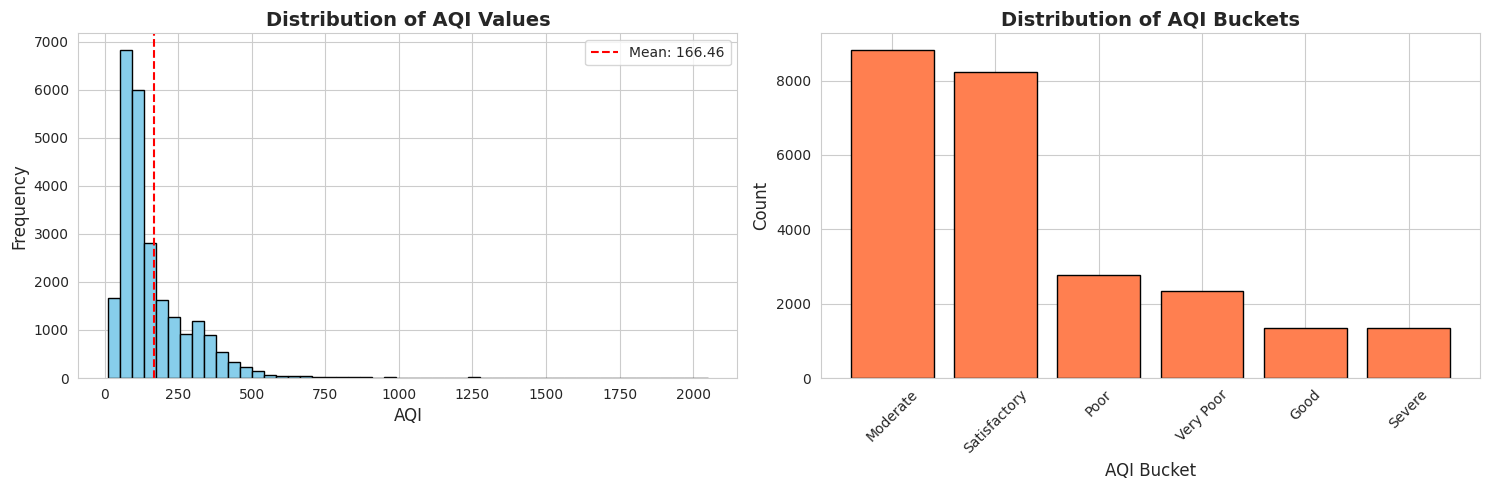


AQI Statistics:
Mean AQI: 166.46
Median AQI: 118.00
Min AQI: 13.00
Max AQI: 2049.00


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# AQI distribution
axes[0].hist(df['AQI'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of AQI Values', fontsize=14, fontweight='bold')
axes[0].set_xlabel('AQI', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].axvline(df['AQI'].mean(), color='red', linestyle='--', label=f'Mean: {df["AQI"].mean():.2f}')
axes[0].legend()

# AQI Bucket distribution
aqi_bucket_counts = df['AQI_Bucket'].value_counts()
axes[1].bar(aqi_bucket_counts.index, aqi_bucket_counts.values, color='coral', edgecolor='black')
axes[1].set_title('Distribution of AQI Buckets', fontsize=14, fontweight='bold')
axes[1].set_xlabel('AQI Bucket', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
print(f"\nAQI Statistics:")
print(f"Mean AQI: {df['AQI'].mean():.2f}")
print(f"Median AQI: {df['AQI'].median():.2f}")
print(f"Min AQI: {df['AQI'].min():.2f}")
print(f"Max AQI: {df['AQI'].max():.2f}")

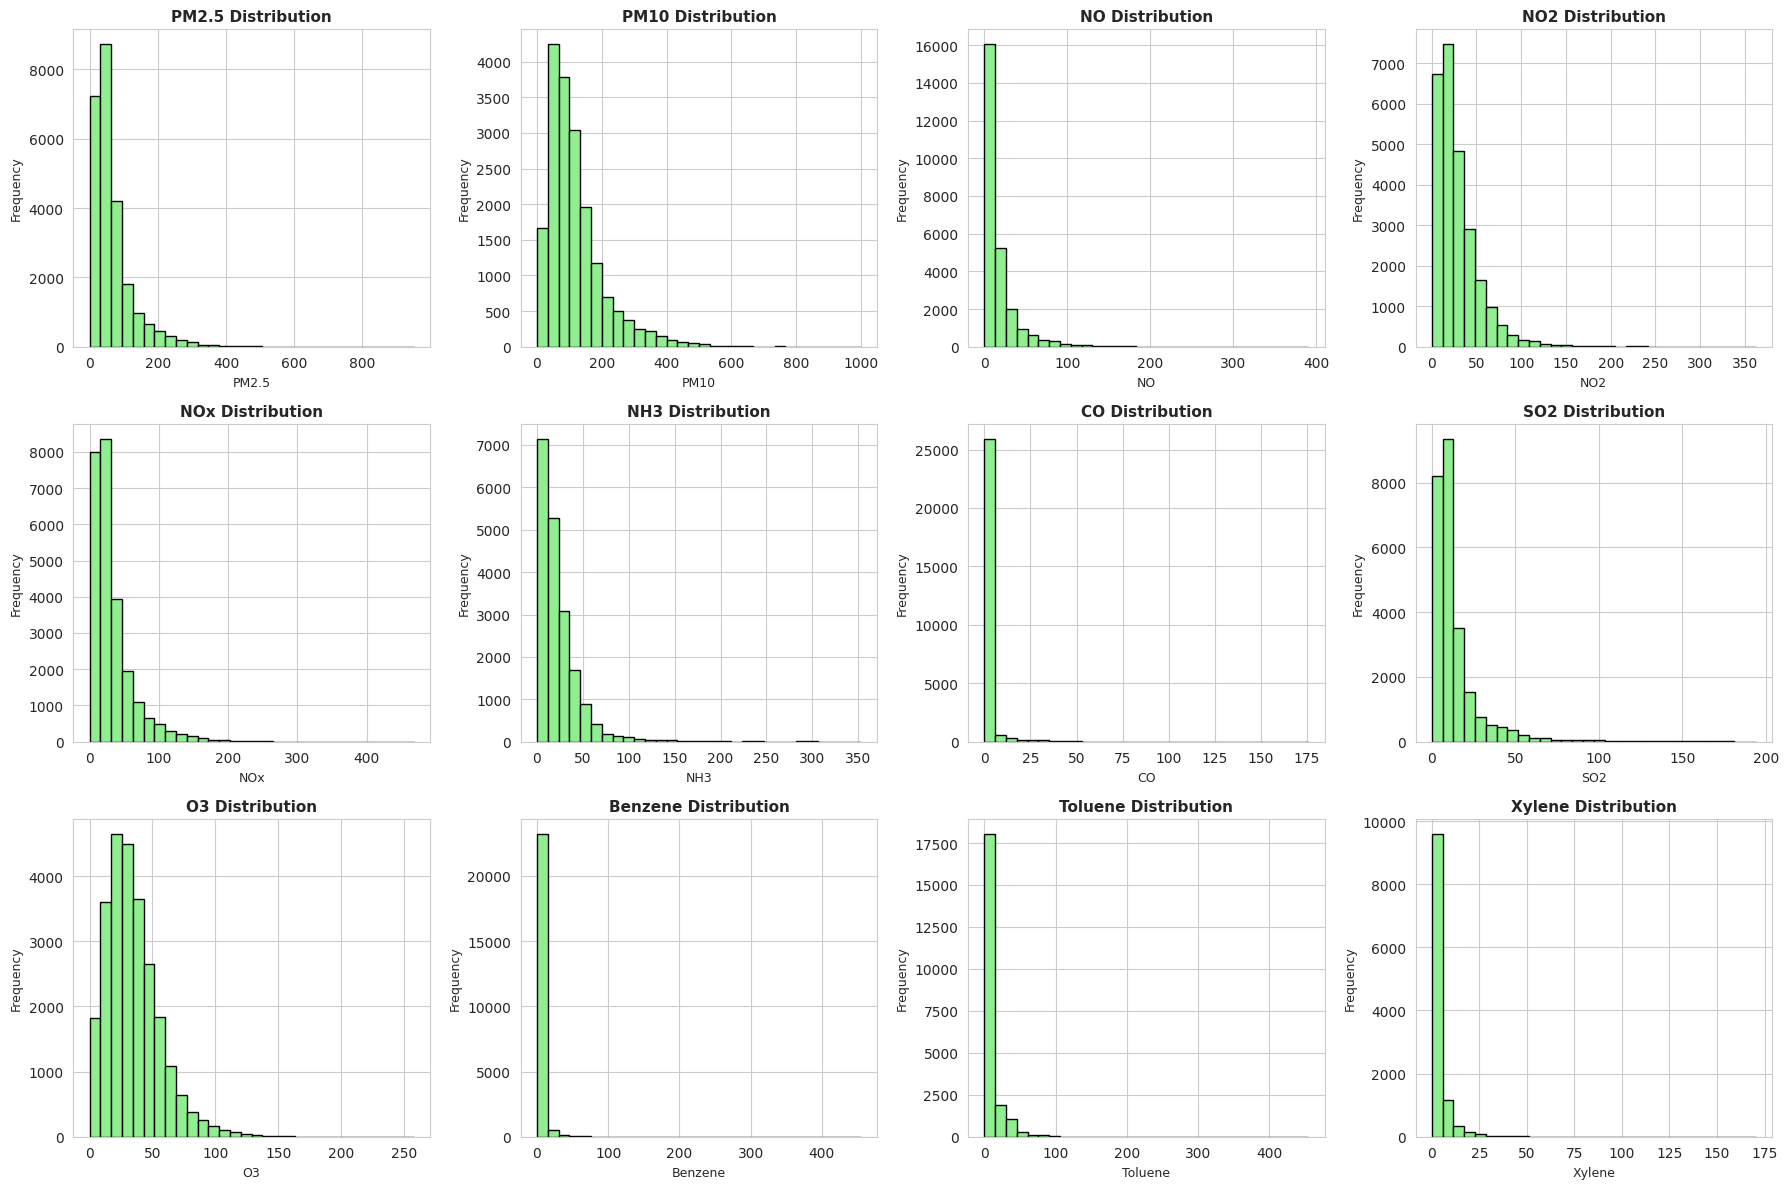

In [10]:
# Pollutant Analysis
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

# Remove pollutants with too many missing values
available_pollutants = [p for p in pollutants if p in df.columns and df[p].notna().sum() > 100]

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.flatten()

for idx, pollutant in enumerate(available_pollutants):
    if idx < len(axes):
        axes[idx].hist(df[pollutant].dropna(), bins=30, color='lightgreen', edgecolor='black')
        axes[idx].set_title(f'{pollutant} Distribution', fontsize=11, fontweight='bold')
        axes[idx].set_xlabel(pollutant, fontsize=9)
        axes[idx].set_ylabel('Frequency', fontsize=9)

# Hide unused subplots
for idx in range(len(available_pollutants), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

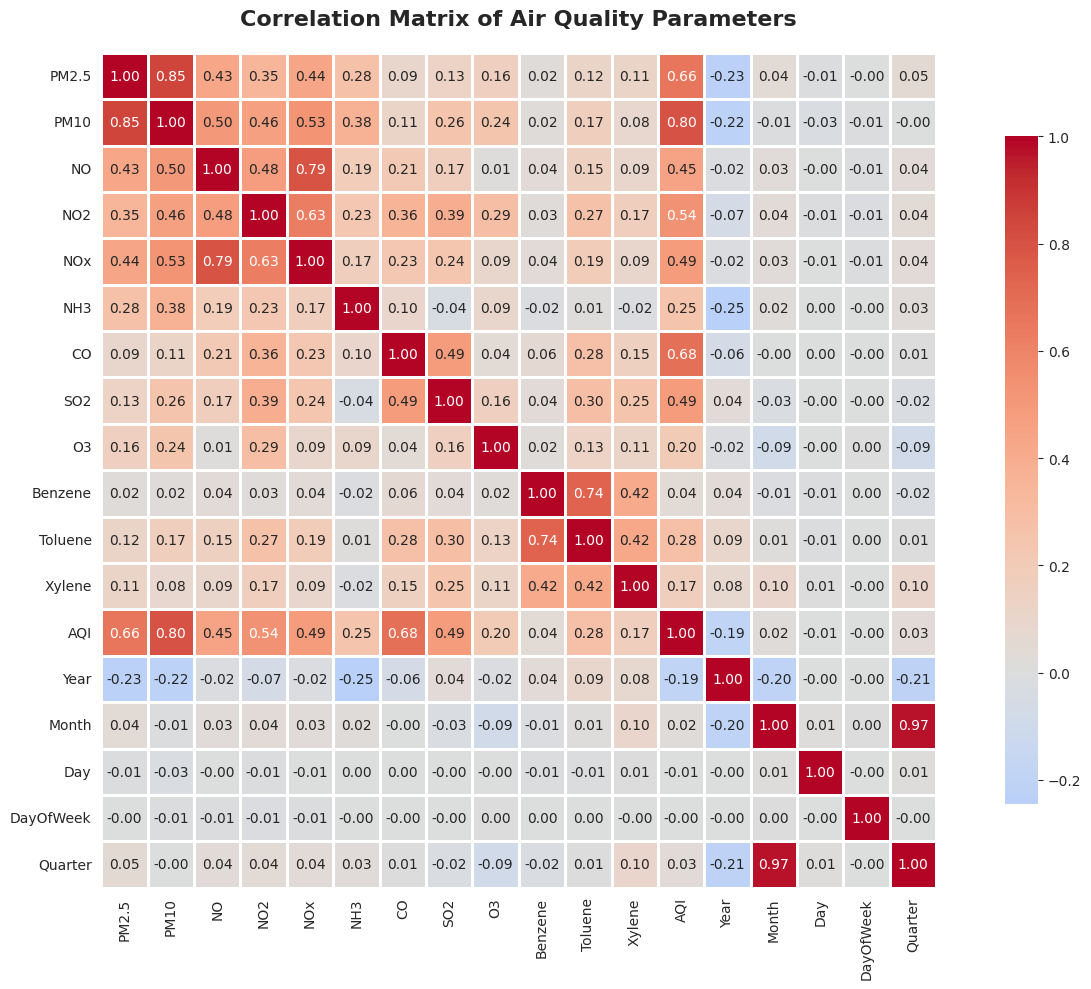


Correlation with AQI:
PM10       0.803313
CO         0.683346
PM2.5      0.659181
NO2        0.537071
SO2        0.490586
NOx        0.486450
NO         0.452191
Toluene    0.279992
NH3        0.252019
O3         0.198991
Name: AQI, dtype: float64


In [11]:
# Select numeric columns for correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Air Quality Parameters', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Show strong correlations with AQI
if 'AQI' in correlation_matrix.columns:
    aqi_corr = correlation_matrix['AQI'].sort_values(ascending=False)
    print("\nCorrelation with AQI:")
    print(aqi_corr[1:11])

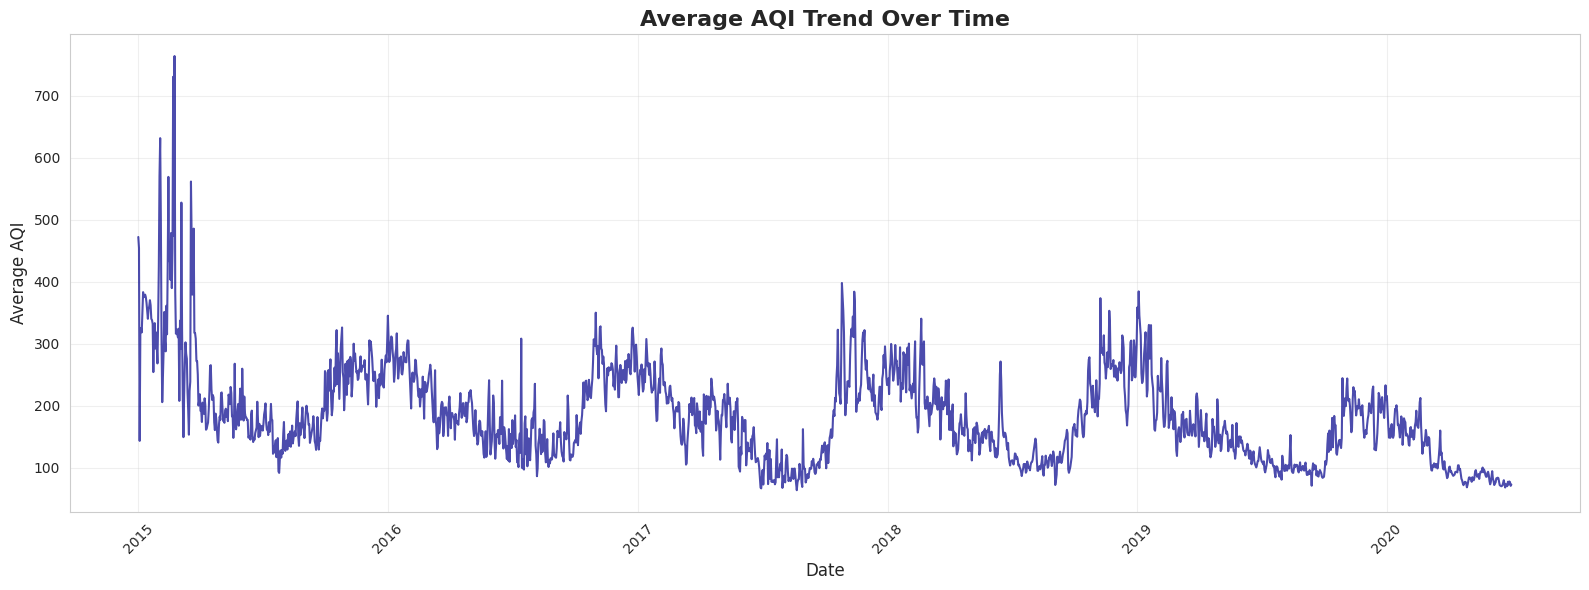

In [12]:
# AQI trend over time
df_time = df.groupby('Date')['AQI'].mean().reset_index()

plt.figure(figsize=(16, 6))
plt.plot(df_time['Date'], df_time['AQI'], linewidth=1.5, color='darkblue', alpha=0.7)
plt.title('Average AQI Trend Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

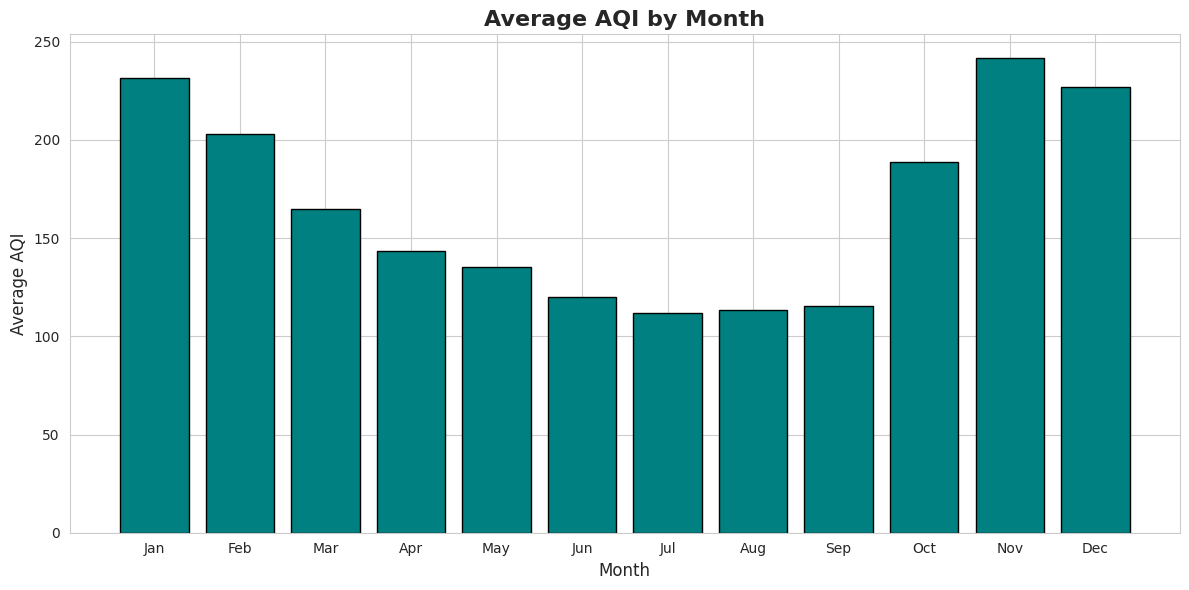

In [13]:
# Monthly average AQI
monthly_aqi = df.groupby('Month')['AQI'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(monthly_aqi['Month'], monthly_aqi['AQI'], color='teal', edgecolor='black')
plt.title('Average AQI by Month', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

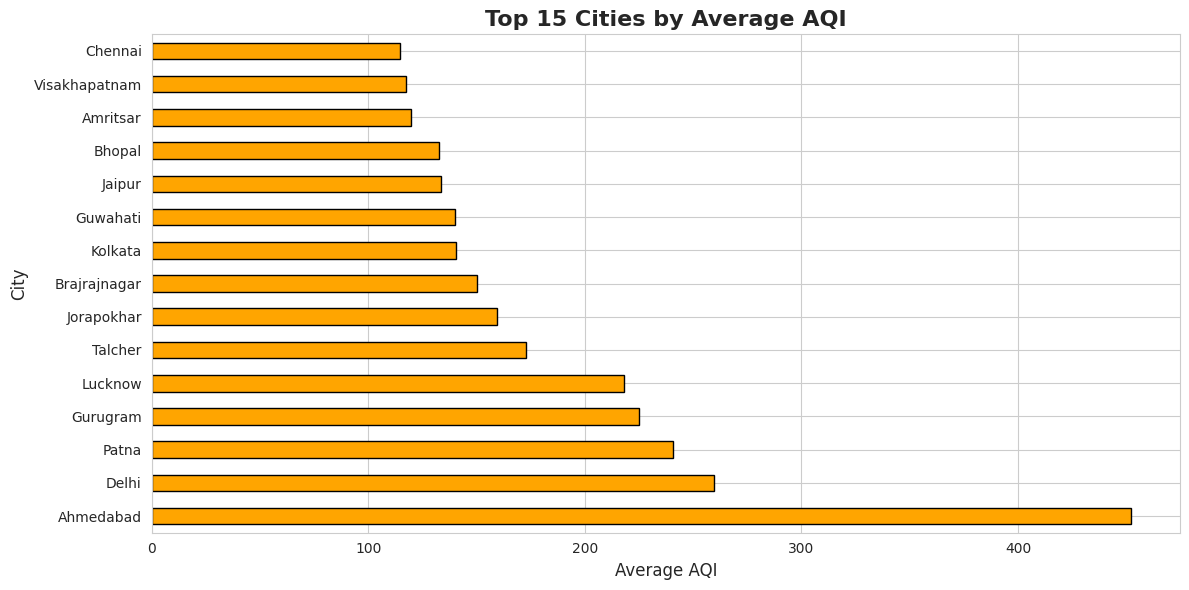

In [14]:
# Top 15 cities by average AQI
city_aqi = df.groupby('City')['AQI'].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
city_aqi.plot(kind='barh', color='orange', edgecolor='black')
plt.title('Top 15 Cities by Average AQI', fontsize=16, fontweight='bold')
plt.xlabel('Average AQI', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()

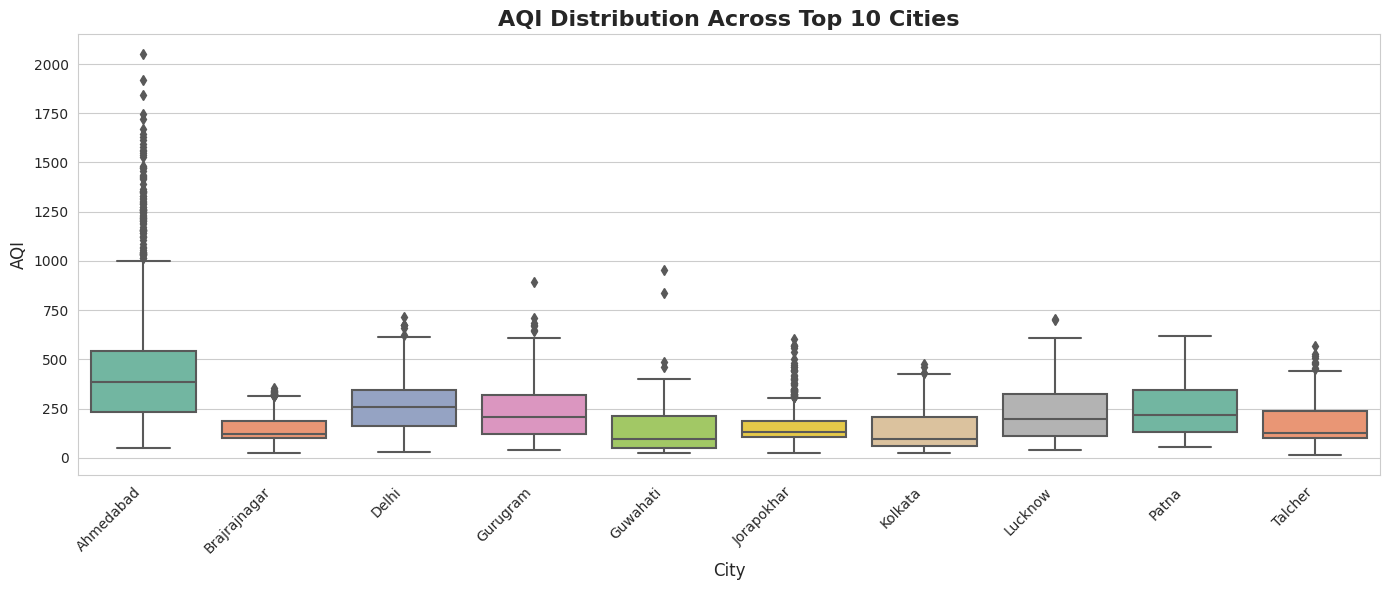

In [15]:
# AQI distribution across top cities
top_cities = city_aqi.head(10).index
df_top_cities = df[df['City'].isin(top_cities)]

plt.figure(figsize=(14, 6))
sns.boxplot(data=df_top_cities, x='City', y='AQI', palette='Set2')
plt.title('AQI Distribution Across Top 10 Cities', fontsize=16, fontweight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('AQI', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

SEASONAL AQI ANALYSIS
          mean  median     std
Season                        
Autumn  183.91   122.0  162.46
Spring  147.67   115.0  116.47
Summer  115.66    90.0   97.32
Winter  220.61   171.0  157.30


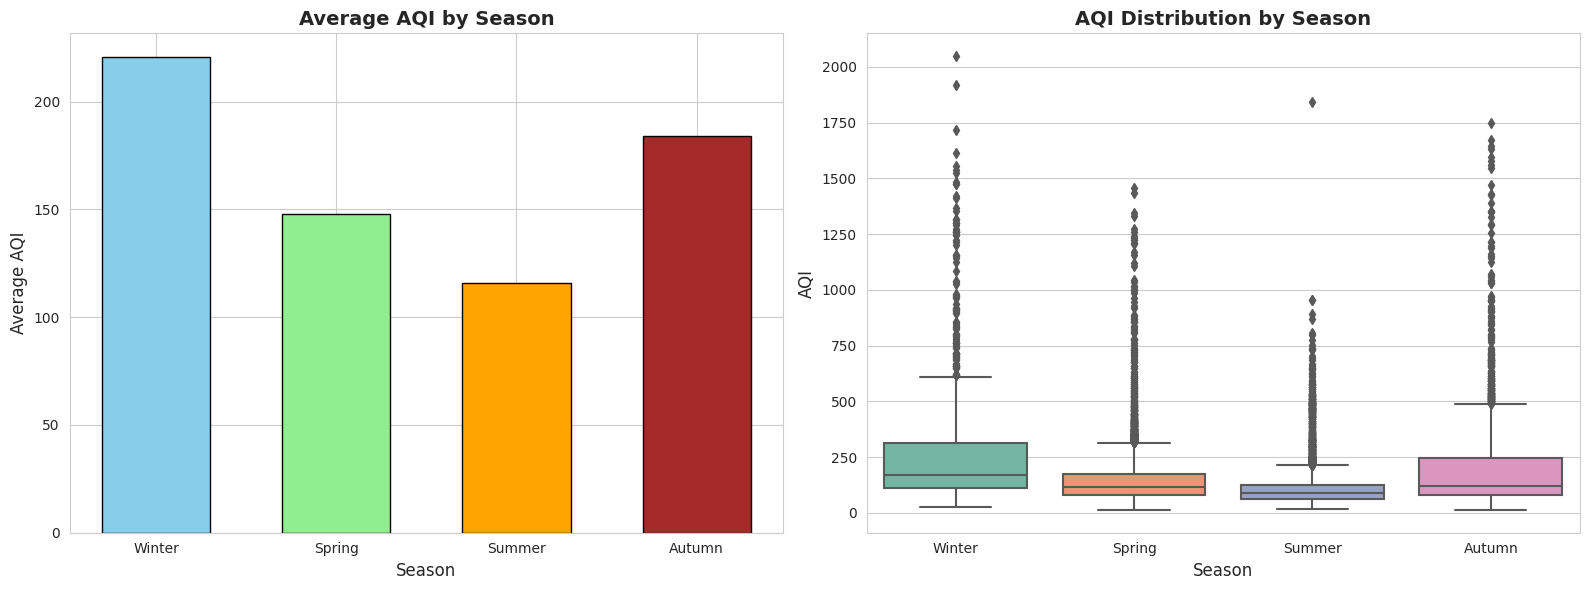

In [16]:
# Create season mapping
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(get_season)

# Seasonal AQI analysis
seasonal_aqi = df.groupby('Season')['AQI'].agg(['mean', 'median', 'std']).round(2)
print("=" * 50)
print("SEASONAL AQI ANALYSIS")
print("=" * 50)
print(seasonal_aqi)

# Visualize seasonal patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Seasonal averages
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_data = df.groupby('Season')['AQI'].mean().reindex(season_order)
axes[0].bar(season_order, seasonal_data.values, color=['skyblue', 'lightgreen', 'orange', 'brown'], 
            edgecolor='black', width=0.6)
axes[0].set_title('Average AQI by Season', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average AQI', fontsize=12)
axes[0].set_xlabel('Season', fontsize=12)

# Seasonal boxplots
sns.boxplot(data=df, x='Season', y='AQI', order=season_order, palette='Set2', ax=axes[1])
axes[1].set_title('AQI Distribution by Season', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AQI', fontsize=12)
axes[1].set_xlabel('Season', fontsize=12)

plt.tight_layout()
plt.show()

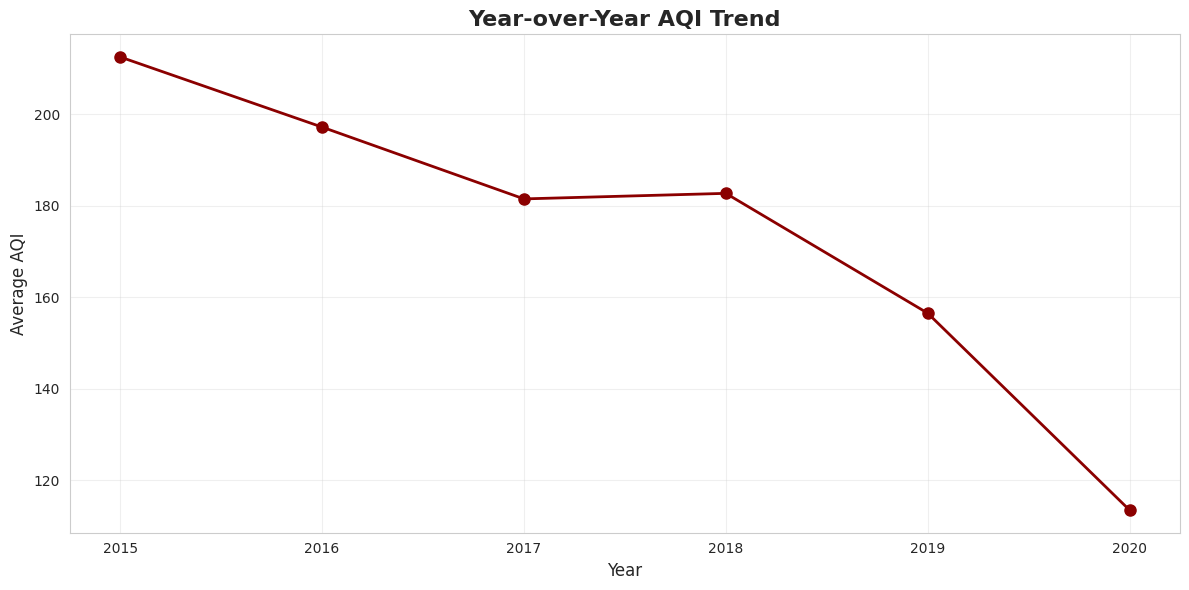


Yearly AQI Summary:
   Year         AQI
0  2015  212.463054
1  2016  197.150019
2  2017  181.472789
3  2018  182.684312
4  2019  156.518173
5  2020  113.520697


In [17]:
yearly_aqi = df.groupby('Year')['AQI'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_aqi['Year'], yearly_aqi['AQI'], marker='o', linewidth=2, 
         markersize=8, color='darkred')
plt.title('Year-over-Year AQI Trend', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average AQI', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(yearly_aqi['Year'])
plt.tight_layout()
plt.show()

print("\nYearly AQI Summary:")
print(yearly_aqi)

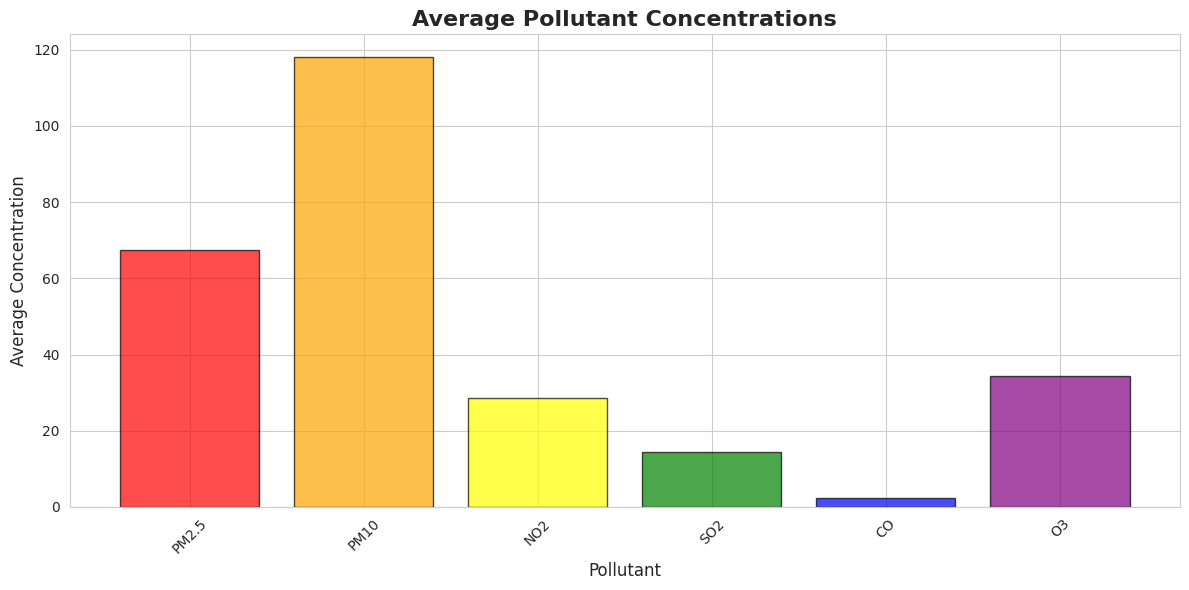

In [18]:
pollutant_avgs = {}
for pollutant in ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']:
    if pollutant in df.columns:
        pollutant_avgs[pollutant] = df[pollutant].mean()

if pollutant_avgs:
    plt.figure(figsize=(12, 6))
    plt.bar(pollutant_avgs.keys(), pollutant_avgs.values(), 
            color=['red', 'orange', 'yellow', 'green', 'blue', 'purple'], 
            edgecolor='black', alpha=0.7)
    plt.title('Average Pollutant Concentrations', fontsize=16, fontweight='bold')
    plt.ylabel('Average Concentration', fontsize=12)
    plt.xlabel('Pollutant', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<Figure size 1600x800 with 0 Axes>

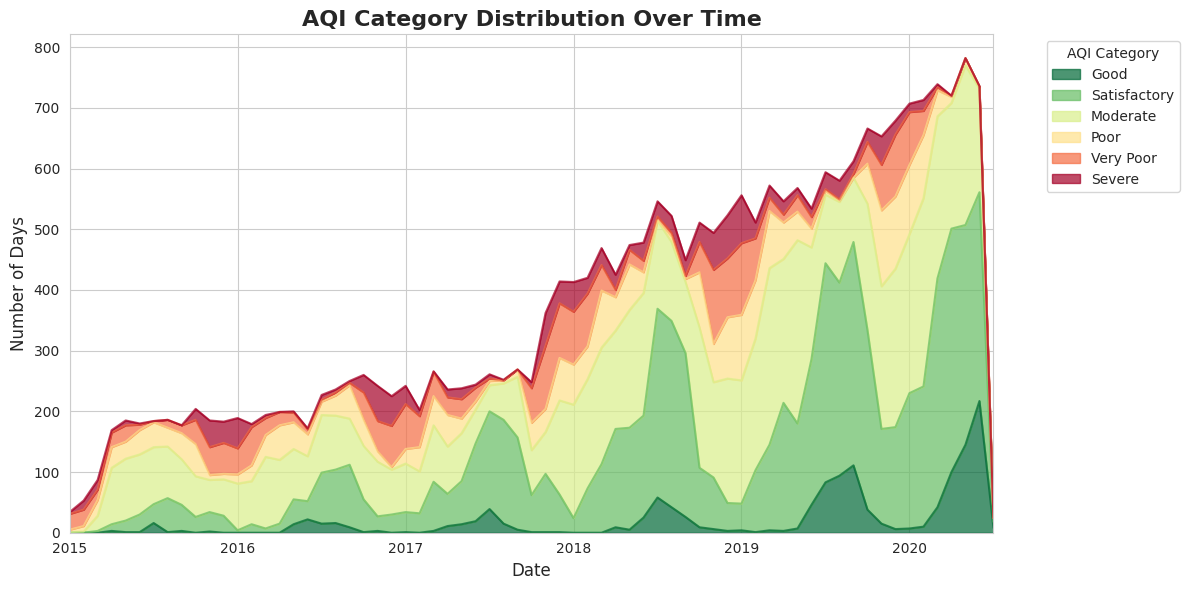

In [19]:
# Define AQI categories with proper order
aqi_category_order = ['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe']

# Filter only existing categories
existing_categories = [cat for cat in aqi_category_order if cat in df['AQI_Bucket'].values]

# Category distribution over time
df_category_time = df.groupby([df['Date'].dt.to_period('M'), 'AQI_Bucket']).size().unstack(fill_value=0)

plt.figure(figsize=(16, 8))
df_category_time[existing_categories].plot(kind='area', stacked=True, 
                                            colormap='RdYlGn_r', alpha=0.7)
plt.title('AQI Category Distribution Over Time', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Days', fontsize=12)
plt.legend(title='AQI Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

TOP 20 MOST POLLUTED DAYS
      Date      City    AQI  PM2.5   PM10 AQI_Bucket
2018-02-19 Ahmedabad 2049.0 242.66    NaN     Severe
2018-02-10 Ahmedabad 1917.0 185.77    NaN     Severe
2016-07-14 Ahmedabad 1842.0  38.13    NaN     Severe
2017-11-14 Ahmedabad 1747.0 207.19    NaN     Severe
2019-01-03 Ahmedabad 1719.0 131.50    NaN     Severe
2018-11-18 Ahmedabad 1672.0 127.46    NaN     Severe
2018-11-21 Ahmedabad 1646.0  86.52    NaN     Severe
2018-11-08 Ahmedabad 1630.0 205.21    NaN     Severe
2018-02-01 Ahmedabad 1613.0 189.12    NaN     Severe
2019-10-13 Ahmedabad 1595.0 194.36 335.86     Severe
2017-11-13 Ahmedabad 1577.0 119.17    NaN     Severe
2018-10-23 Ahmedabad 1561.0 129.98    NaN     Severe
2018-12-22 Ahmedabad 1558.0 111.75    NaN     Severe
2018-11-13 Ahmedabad 1548.0 133.13    NaN     Severe
2019-01-21 Ahmedabad 1537.0 149.26    NaN     Severe
2018-02-23 Ahmedabad 1526.0 138.40    NaN     Severe
2018-02-22 Ahmedabad 1483.0  91.66    NaN     Severe
2018-02-18 Ahmedabad

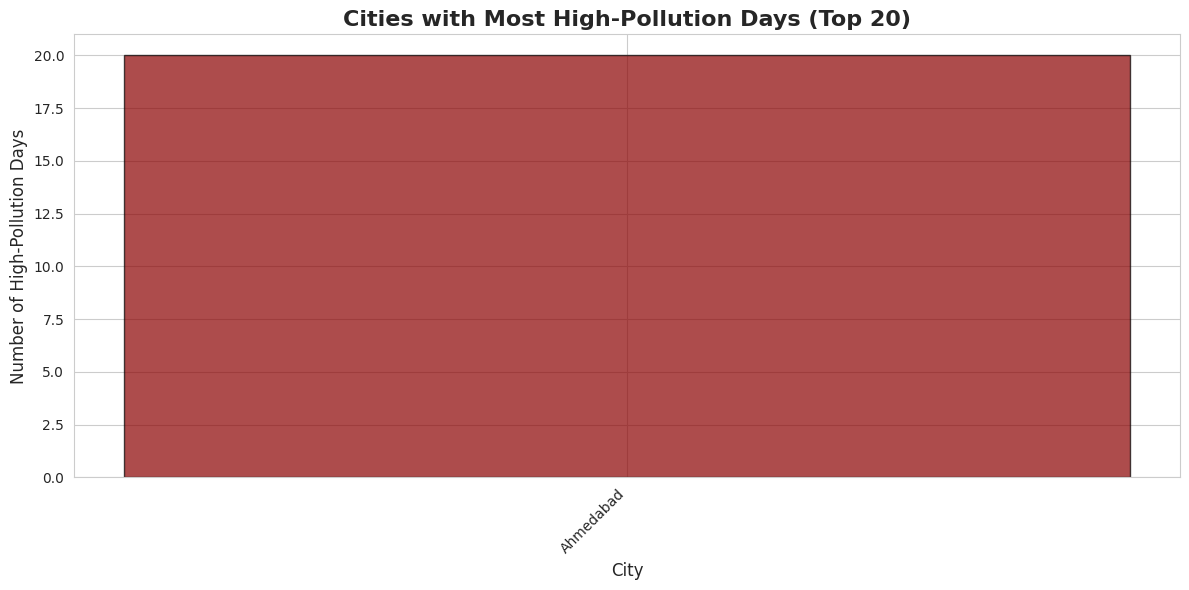

In [20]:
# Get top 20 most polluted days
top_polluted_days = df.nlargest(20, 'AQI')[['Date', 'City', 'AQI', 'PM2.5', 'PM10', 'AQI_Bucket']]

print("=" * 50)
print("TOP 20 MOST POLLUTED DAYS")
print("=" * 50)
print(top_polluted_days.to_string(index=False))

# Visualize top polluted cities
plt.figure(figsize=(12, 6))
top_polluted_cities = top_polluted_days['City'].value_counts()
plt.bar(top_polluted_cities.index, top_polluted_cities.values, 
        color='darkred', edgecolor='black', alpha=0.7)
plt.title('Cities with Most High-Pollution Days (Top 20)', fontsize=16, fontweight='bold')
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of High-Pollution Days', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


WEEKDAY VS WEEKEND AQI ANALYSIS
             mean  median     std
IsWeekend                        
Weekday    167.25   118.0  141.68
Weekend    164.50   118.0  138.20


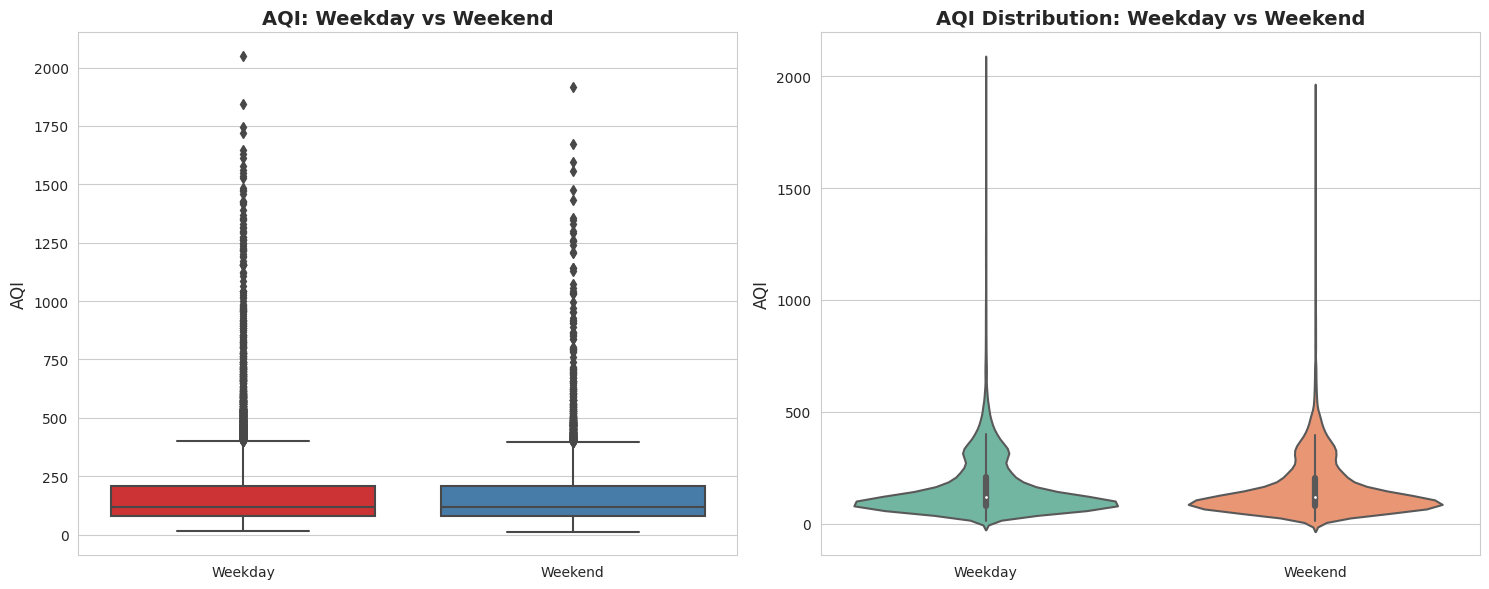

In [21]:
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

weekday_analysis = df.groupby('IsWeekend')['AQI'].agg(['mean', 'median', 'std']).round(2)
print("\n" + "=" * 50)
print("WEEKDAY VS WEEKEND AQI ANALYSIS")
print("=" * 50)
print(weekday_analysis)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
sns.boxplot(data=df, x='IsWeekend', y='AQI', palette='Set1', ax=axes[0])
axes[0].set_title('AQI: Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[0].set_ylabel('AQI', fontsize=12)
axes[0].set_xlabel('', fontsize=12)

# Violin plot
sns.violinplot(data=df, x='IsWeekend', y='AQI', palette='Set2', ax=axes[1])
axes[1].set_title('AQI Distribution: Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AQI', fontsize=12)
axes[1].set_xlabel('', fontsize=12)

plt.tight_layout()
plt.show()

In [22]:
# Create comprehensive city rankings
city_stats = df.groupby('City').agg({
    'AQI': ['mean', 'median', 'max', 'std'],
    'PM2.5': 'mean',
    'PM10': 'mean'
}).round(2)

city_stats.columns = ['_'.join(col).strip() for col in city_stats.columns.values]
city_stats = city_stats.sort_values('AQI_mean', ascending=False).head(15)

print("\n" + "=" * 50)
print("TOP 15 CITIES - COMPREHENSIVE STATISTICS")
print("=" * 50)
print(city_stats)


TOP 15 CITIES - COMPREHENSIVE STATISTICS
               AQI_mean  AQI_median  AQI_max  AQI_std  PM2.5_mean  PM10_mean
City                                                                        
Ahmedabad        452.12       384.5   2049.0   311.73       67.85     114.58
Delhi            259.49       257.0    716.0   119.54      117.20     232.81
Patna            240.78       215.0    619.0   122.34      123.50     126.75
Gurugram         225.12       208.0    891.0   119.94      117.10     191.50
Lucknow          217.97       198.0    707.0   116.96      109.71        NaN
Talcher          172.89       128.5    570.0   104.87       61.41     165.77
Jorapokhar       159.25       133.0    604.0    84.70       64.23     149.66
Brajrajnagar     150.28       122.0    355.0    70.37       64.06     124.22
Kolkata          140.57        94.0    475.0   104.49       64.36     115.63
Guwahati         140.11        98.0    956.0   112.76       63.69     116.60
Jaipur           133.68       122.


LAG CORRELATION ANALYSIS
               AQI  AQI_lag1  AQI_lag7
AQI       1.000000  0.881282  0.717630
AQI_lag1  0.881282  1.000000  0.726556
AQI_lag7  0.717630  0.726556  1.000000


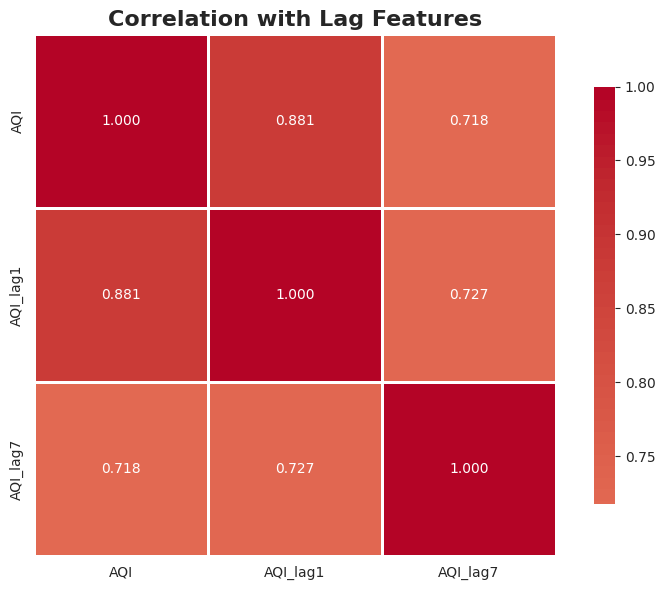

In [23]:
# Create lag features for time series analysis
df_sorted = df.sort_values(['City', 'Date'])
df_sorted['AQI_lag1'] = df_sorted.groupby('City')['AQI'].shift(1)
df_sorted['AQI_lag7'] = df_sorted.groupby('City')['AQI'].shift(7)

# Check correlation
lag_corr = df_sorted[['AQI', 'AQI_lag1', 'AQI_lag7']].corr()

print("\n" + "=" * 50)
print("LAG CORRELATION ANALYSIS")
print("=" * 50)
print(lag_corr)

plt.figure(figsize=(8, 6))
sns.heatmap(lag_corr, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=2, cbar_kws={"shrink": 0.8})
plt.title('Correlation with Lag Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [24]:
# Create a modeling dataset
df_model = df.copy()

# Select features for modeling
feature_cols = ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']
available_features = [col for col in feature_cols if col in df_model.columns]

# Target variable
target = 'AQI'

# Remove rows where target is missing
df_model = df_model.dropna(subset=[target])

In [25]:
# Prepare X and y
X = df_model[available_features].copy()
y = df_model[target].copy()

# Handle missing values in features using imputation
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

print(f"Modeling dataset shape: {X_imputed.shape}")
print(f"Target variable shape: {y.shape}")
print(f"\nFeatures used: {available_features}")

Modeling dataset shape: (24850, 11)
Target variable shape: (24850,)

Features used: ['PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter']


In [26]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [27]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (19880, 11)
Test set size: (4970, 11)


In [28]:
print("LINEAR REGRESSION")

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Metrics
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R² Score: {lr_r2:.4f}")

LINEAR REGRESSION
RMSE: 59.3957
MAE: 31.0094
R² Score: 0.8073


In [29]:
print("RANDOM FOREST REGRESSOR")

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Metrics
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R² Score: {rf_r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))


RANDOM FOREST REGRESSOR
RMSE: 41.0338
MAE: 21.3388
R² Score: 0.9080

Top 10 Feature Importances:
     Feature  Importance
0      PM2.5    0.493998
4         CO    0.396875
1       PM10    0.037881
5         O3    0.015999
2        NO2    0.014373
3        SO2    0.014018
6       Year    0.009511
8        Day    0.007934
7      Month    0.004386
9  DayOfWeek    0.003846


In [30]:
print("GRADIENT BOOSTING REGRESSOR")

gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)

# Metrics
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

print(f"RMSE: {gb_rmse:.4f}")
print(f"MAE: {gb_mae:.4f}")
print(f"R² Score: {gb_r2:.4f}")

GRADIENT BOOSTING REGRESSOR
RMSE: 43.4564
MAE: 23.6518
R² Score: 0.8969


MODEL COMPARISON
               Model       RMSE        MAE  R² Score
0  Linear Regression  59.395705  31.009352  0.807337
1      Random Forest  41.033815  21.338760  0.908046
2  Gradient Boosting  43.456368  23.651779  0.896868


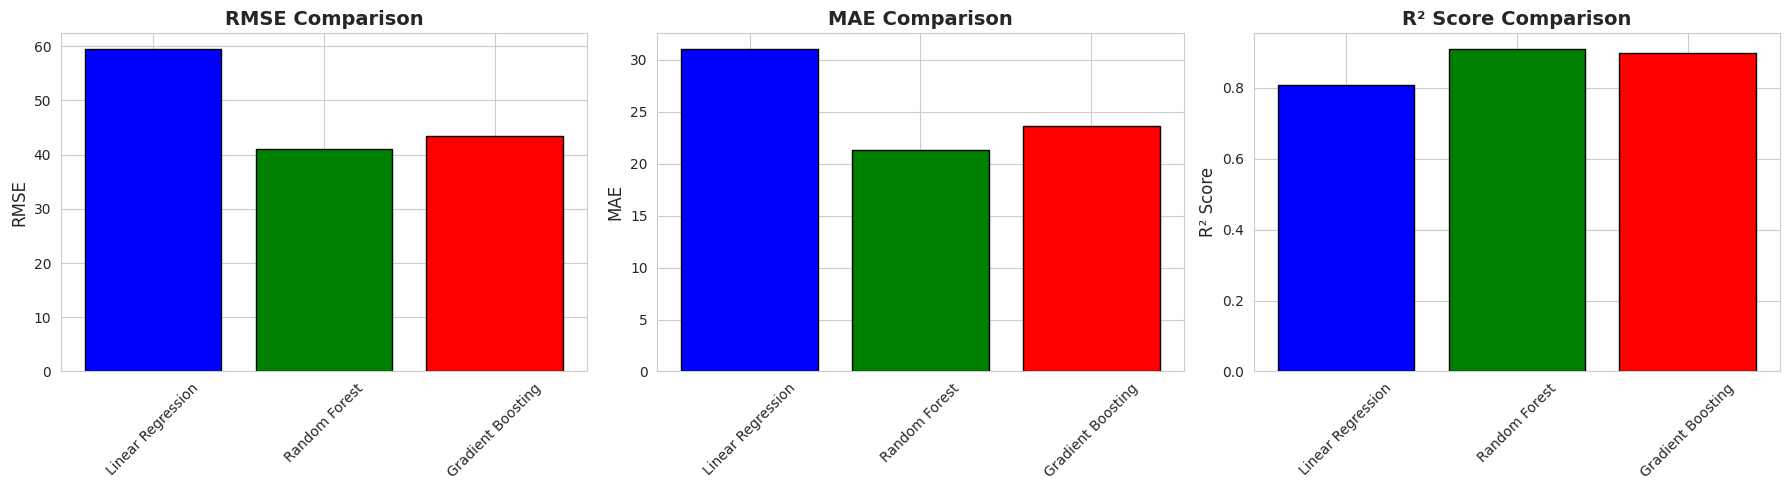

In [31]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'RMSE': [lr_rmse, rf_rmse, gb_rmse],
    'MAE': [lr_mae, rf_mae, gb_mae],
    'R² Score': [lr_r2, rf_r2, gb_r2]
})

print("=" * 50)
print("MODEL COMPARISON")
print("=" * 50)
print(results)

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
axes[0].bar(results['Model'], results['RMSE'], color=['blue', 'green', 'red'], edgecolor='black')
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('RMSE', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1].bar(results['Model'], results['MAE'], color=['blue', 'green', 'red'], edgecolor='black')
axes[1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
axes[2].bar(results['Model'], results['R² Score'], color=['blue', 'green', 'red'], edgecolor='black')
axes[2].set_title('R² Score Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()